## 국면분석 Baseline model 

2019.1.23 Mr.Big

### 개요
주가 데이터를 활용하여 군집분석 방법론 및 모델구현 가능성을 빠르게 점검하고  
향후 최종모델 개발을 위한 개선 아이디어 도출

### 방법론

1. 데이터 준비
  - 코스피 수익률 데이터를 일자별로 과거 20일치를 피처(컬럼) 세트로 구성
2. 기초분석 
  - 주가 수익률 분포 탐색 : 기초통계분석, 상관분석, PCA 
  - 적정 군집수 탐색 : elbow method 분석
3. 모델링
  - k-means 외 사이킷런에서 제공하는 다양한 군집분석 알고리즘 비교 분석
4. 평가 
  - 세그먼트 당 관측치수 적정성 : 특정 군집에 관측치가 쏠리거나 군집이 제대로 형성되지 않는지?
  - 실루엣 지수 : 군집 밀집도 평가지표(완전히 검증되지 않은 지표로 복잡한 분포에는 성능이 떨어지는 단점)
  - 직접 보고 해석하기 : 군집내 관측치를 주가차트로 구현하여 유사도 해석
5. 대안 제시
  - 피처 엔지니어링 관점 : 새로운 피처의 추가, 변환 또는 축소(PCA 등)
  - 모델링 방법 관점 
  - 패러다임 쉬프트 : 발상의 전환

---
**시작에 앞서 ...**

군집분석 모델링은 사이킷런 튜토리얼에서 상당부분 아이디어를 가져온 것임  https://goo.gl/25Mzqe  
특히 아래 그림은 반복적으로 인용되고 평가 기준이 되니, 반드시 숙지할 필요 있음

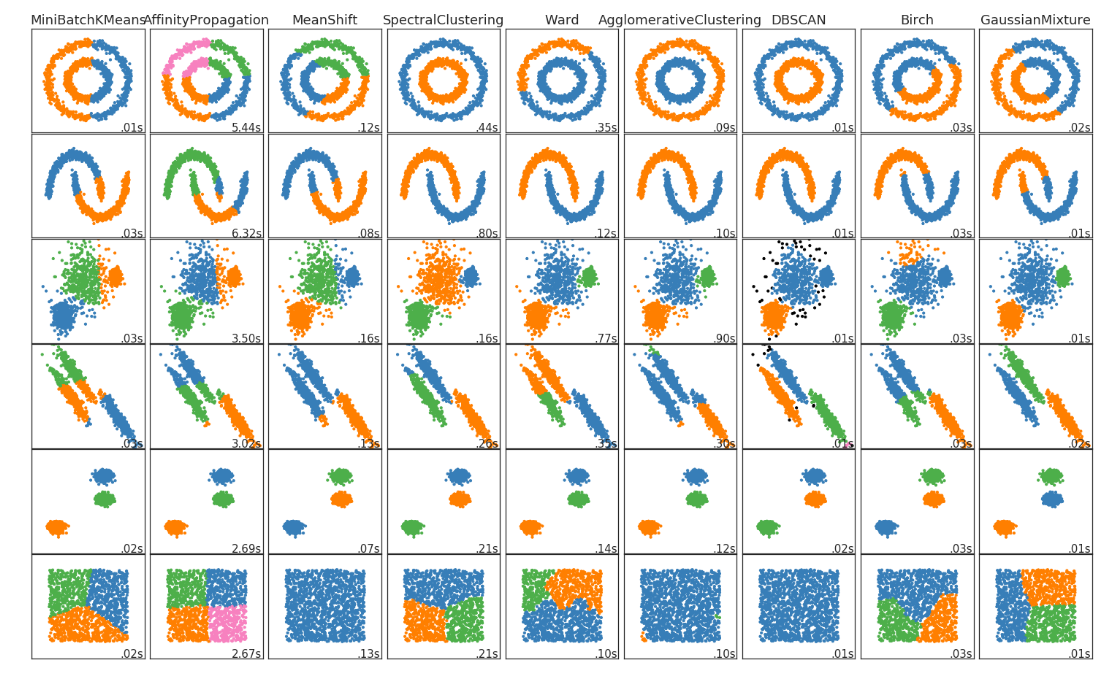

In [1]:
from IPython.display import Image    
Image("images/comparing_cluster.png")

---

### 데이터 준비

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib 

matplotlib.rcParams['axes.unicode_minus'] = False   # 마이너스 부호 깨짐 방지
%matplotlib inline

import seaborn as sns
sns.set(style='ticks', color_codes=True)

import warnings                                     # 경고문구 출력 제한
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = FutureWarning)
 
from IPython.display import Markdown                # 마크다운 포맷 출력
def bold(string):
    display(Markdown(string))

In [3]:
from sklearn.cluster import KMeans

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from itertools import cycle, islice

#### 종가 기준으로 수익률 생성

**관측치 수 : 4,404**

**코스피 지수 분포**

count    4404.000000
mean     1553.848218
std       568.080508
min       468.760000
25%       988.532500
50%      1742.470000
75%      1992.642500
max      2598.190000
Name: IDX_CLPR, dtype: float64

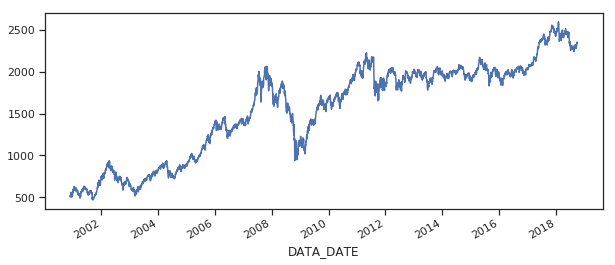

In [4]:
kospi = pd.read_csv('data/kospi.csv',  encoding='ms949')

bold('**관측치 수 : {:,}**'.format(len(kospi)))
bold('**코스피 지수 분포**')
display(kospi['IDX_CLPR'].describe())

df_kospi = kospi['IDX_CLPR']
df_kospi.index = pd.to_datetime(kospi['DATA_DATE'])

plt.figure(figsize=(10,4))
df_kospi.plot()
plt.show()

---

#### 수익률 계산 후 과거 20일치 데이터를 피처로 변환


_20일치 데이터를 피처로 만드는 로직_  
1. 20개 요소값을 갖는 np.ones 벡터를 만든다(더미벡터)
2. 코스피 수익률 데이터에서 20번째 행부터 lag 벡터를 만든다(iloc활용)
3. 일자별 작업시마다 np.vstack으로 쌓는다.
4. 마지막 행까지 완료시 -> 첫행의 np.ones는 날리고 데이터프레임 변환
5. 인덱스에 코스피 날짜를 넣는다. 

In [5]:
def vector_to_columns(ser, col_num=20):
    """
    수익률 벡터를 받아서, 과거 20일치를 컬럼 피처로 만든다. 
    """
    result = np.ones(col_num)                             # 첫 행에 원소수가 똑같은(20개) 더미 벡터 만든다. 
    for end in np.arange(col_num,len(ser)):               # 20번째 행부터 시작한다. 
        start = end-(col_num-1)
        col_vec = rets.iloc[start:end+1].values           # 과거 20일치 수익률 땡겨와서 벡터로 저장
        result = np.vstack([result, col_vec])    
    result = result[1:,:]                                 # 더미 벡터는 날린다. 
    return result
    
rets = np.log(df_kospi/df_kospi.shift(1))                 # 로그 수익률    
result_arr = vector_to_columns(rets, 20)               
bold('** 데이터 구조 : {}**'.format(result_arr.shape))

varname = ['D'+'_'+str(20-i) for i in range(20)]         # 컬럼명 만든다. D_1은 전일자, D_20일은 20일자

df_kospi_lag = pd.DataFrame(result_arr)
df_kospi_lag.columns = varname
df_kospi_lag.index = rets.index[20:]
display(df_kospi_lag.head())

** 데이터 구조 : (4384, 20)**

,D_20,D_19,D_18,D_17,D_16,D_15,D_14,D_13,D_12,D_11,D_10,D_9,D_8,D_7,D_6,D_5,D_4,D_3,D_2,D_1
DATA_DATE,,,,,,,,,,,,,,,,,,,,
2001-01-05,-0.025056,0.029903,0.001797,0.011309,0.020840,0.036696,-0.021351,0.026816,-0.018929,-0.024747,0.009821,-0.015831,-0.031754,-0.004502,-0.022322,0.007998,0.031848,0.000921,0.067820,0.040098
2001-01-08,0.029903,0.001797,0.011309,0.020840,0.036696,-0.021351,0.026816,-0.018929,-0.024747,0.009821,-0.015831,-0.031754,-0.004502,-0.022322,0.007998,0.031848,0.000921,0.067820,0.040098,0.009936
2001-01-09,0.001797,0.011309,0.020840,0.036696,-0.021351,0.026816,-0.018929,-0.024747,0.009821,-0.015831,-0.031754,-0.004502,-0.022322,0.007998,0.031848,0.000921,0.067820,0.040098,0.009936,0.005559
2001-01-10,0.011309,0.020840,0.036696,-0.021351,0.026816,-0.018929,-0.024747,0.009821,-0.015831,-0.031754,-0.004502,-0.022322,0.007998,0.031848,0.000921,0.067820,0.040098,0.009936,0.005559,-0.050605
2001-01-11,0.020840,0.036696,-0.021351,0.026816,-0.018929,-0.024747,0.009821,-0.015831,-0.031754,-0.004502,-0.022322,0.007998,0.031848,0.000921,0.067820,0.040098,0.009936,0.005559,-0.050605,0.001746


---

### 기초분석

**수익률 기초분석**

**수익률 일자별 변동**

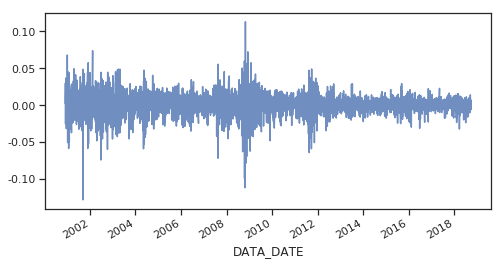

**수익률 분포**

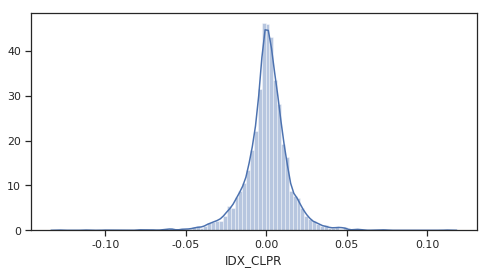

In [6]:
bold('**수익률 일자별 변동**')
plt.figure(figsize=(8,4))
rets.plot(alpha=0.8) 
plt.show()

bold('**수익률 분포**')
plt.figure(figsize=(8,4))
sns.distplot(rets.dropna(), bins=100)
plt.show()

- 2000년대 초반 대비 수익률 변동이 계속 감소하고 있는 추세(위의 표)  
- 수익률이 정규분포의 특성을 갖추고 있음(아래 표)  
- 특이값이 있어 클러스터링 전에 표준화 필요

---
**일자별 수익률 상관분석**  
현재이 주가는 과거일자와 상관관계가 있을까? 

**과거일자별 수익률 상관계수(20일X20일) : 분포 보기 **

count    380.000000
mean      -0.003858
std        0.016564
min       -0.035352
25%       -0.018342
50%        0.002172
75%        0.005674
max        0.026254
dtype: float64

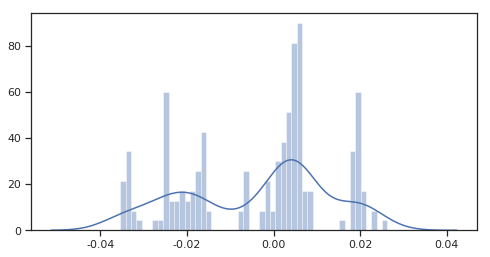

**상관행렬**

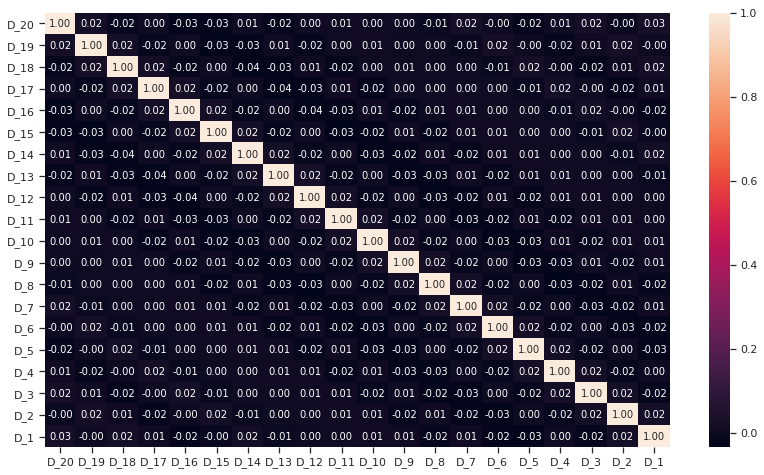

In [7]:
corr = df_kospi_lag.corr()
corr_flatten = corr.values.flatten()
corr_flatten = corr_flatten[np.where(corr_flatten != 1.0)]  # 상관계수 대각행렬에 1값은 지우자

bold('**과거일자별 수익률 상관계수(20일X20일) : 분포 보기 **')
display(pd.Series(corr_flatten).describe())
plt.figure(figsize=(8,4))
sns.distplot(corr_flatten, bins=50)
plt.show()

bold('**상관행렬**')
plt.figure(figsize=(14,8))
sns.heatmap(corr, annot=True, fmt=".2f")                    # 소수점 2자리까지 값 출력
plt.show()

상관계수가 거의 0주위에 몰려있음  
이는 현재일의 수익률이 과거일자에 상관없이 랜덤워크로 움직인다고 해석할 수 있음

---
**PCA를 활용한 데이터 분포 시각화**  
20일 수익률 피처를 2개의 주성분으로 축소하여 2차원 차트 구현

**PCA를 통해 수익률을 2차원 데이터로 축소(값 출력 예시)**

array([[0.00462377, 0.03232015],
       [0.01037992, 0.0411888 ],
       [0.0144301 , 0.01195538]])

**PCA 주성분 산점도**

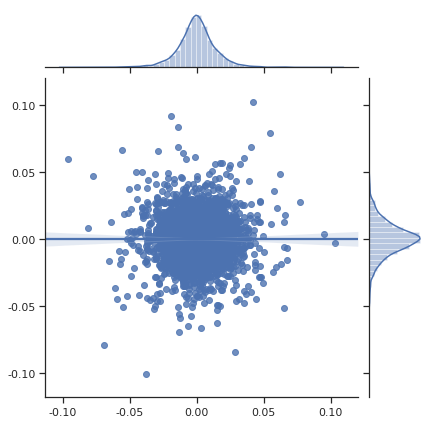

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(df_kospi_lag)

bold('**PCA를 통해 수익률을 2차원 데이터로 축소(값 출력 예시)**')
display(x_pca[:3, :])

bold('**PCA 주성분 산점도**')
sns.jointplot(x=x_pca[:, 0], y=x_pca[:, 1], kind='reg') 
plt.show()

주가수익률 20개의 피처를 PCA를 활용하여 2개의 피처로 요약하여 시각화  
X(1번주성분)와 Y(1번주성분)축 모두 정규분포 형태로 중앙에 밀집되어 아웃라이어 외에는 특별한 패턴이 관측되지 않음

---

별다른 패턴이 없이 중앙에 밀집된 주가 데이터를 어떤 클러스터링 알고리즘이 잘 적합시킬까?  
아래 클러스터링 알고리즘과 데이터 유형에 따른 적합도 차트를 다시 살펴보자   

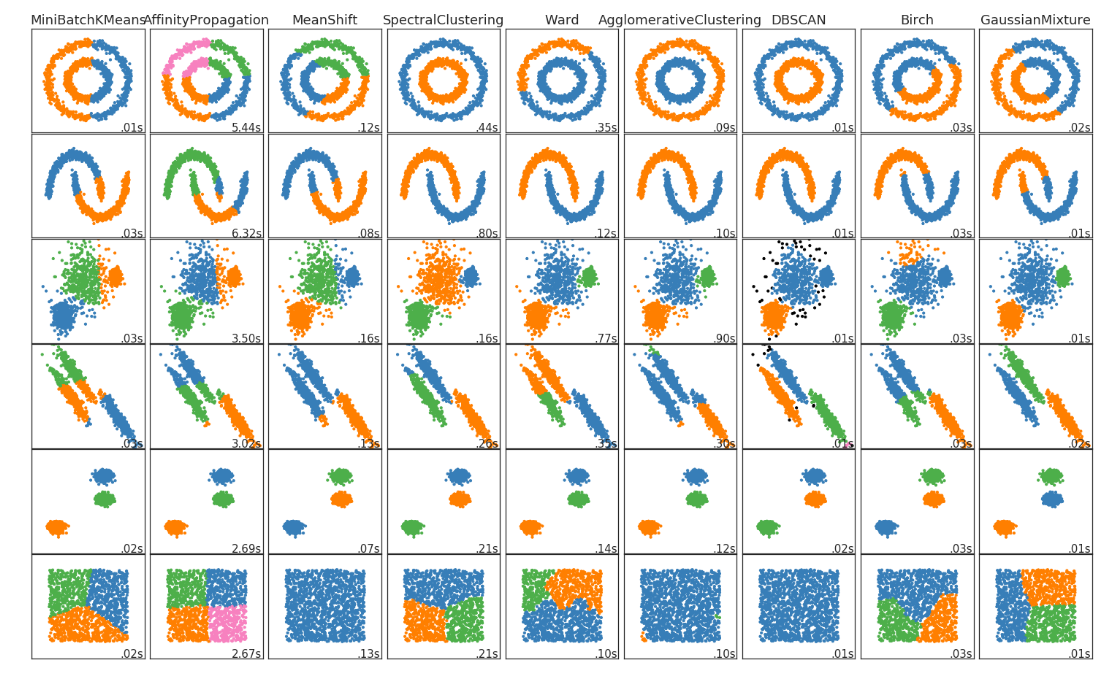

In [9]:
Image("images/comparing_cluster.png")

특히, 코스피 주가 데이터는 **맨 하단의 정사각형에 밀집된 데이터 분포**와 가장 유사한 것으로 보인다. (아래참조)  
밀집유형에 효과성이 있어 보이는 알고리즘은 ... 
- MiniBatch Kmeans
- Affinity Propagation
- Spectral Clustering
- Ward
- Birch
- Gausian Mixture

---
**Elbow method를 활용한 적정 군집수 탐색**

클러스터 수를 1부터 100까지 늘렸을때 inertia값의 변곡점이 발생하는 지점을 찾아보자  
(Inertia값은 군집 각 중심점에서 군집 데이타간의 거리를 합산하여 응집도 나타낸 것)

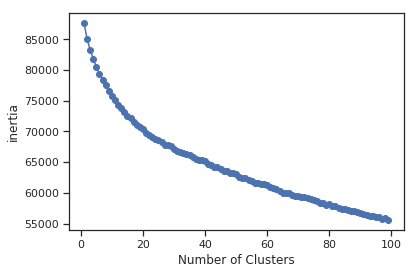

In [10]:
X = StandardScaler().fit_transform(df_kospi_lag)    # 표준화

iter_n = 100                                        # 클러스터 개수 최대값

inertias = []
for i in range(1,iter_n):
    model = KMeans(n_clusters=i)
    model.fit(X)
    inertias.append(model.inertia_)
    
plt.plot(range(1,iter_n), inertias, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('inertia')
#plt.xticks(range(1,iter_n))
plt.show()    

클러스터수 10~20개 정도에서 변곡점이 생긴다고 판단된다.  
k-means와 같이 모델 개수를 지정해야 하는 알고리즘은 **20개**로 통일해서 비교하자

---

### 모델링 및 평가

** 평가 대상 알고리즘**

- MiniBatch KMeans
- Affinity Propagation
- Mean shift
- Spectral Clustering
- Ward
- Agglomerative Clustering
- DBSCAN
- Birch
- Gaussian Mixture

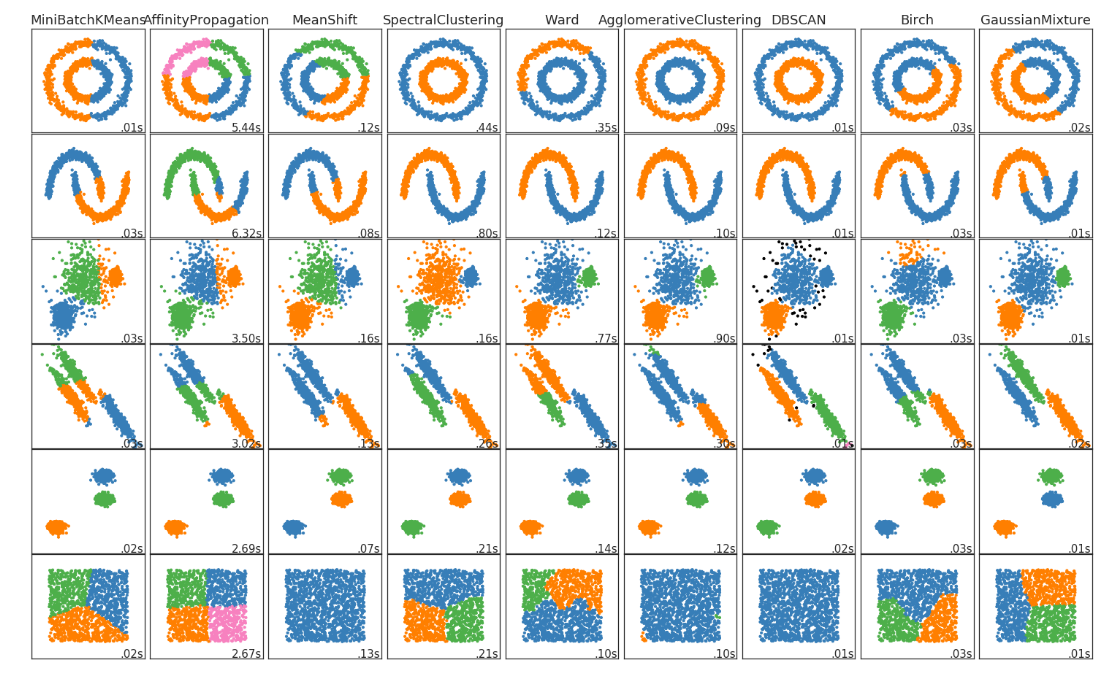

In [11]:
Image("images/comparing_cluster.png")

**평가방법**

1. 군집이 잘 쪼개지고 관측치가 적정하게 배분되는 알고리즘은? --> 시각화 차트로 확인
2. **실루엣 지수값**이 더 큰 알고리즘은?

_※ 실루엣지수란?_    
- 군집의 밀집도 평가지표로 -1일때 잘못된 군집, +1에서의 최적 군집으로 평가
- 관측치에 랜덤으로 클러스터를 할당하여 비교지수를 만듦(벤치마크)
- 복잡한 분포에서는 성능이 떨어지는 단점
- 『파이썬을 활용한 머신러닝』 책 237쪽 참조

선행작업~! 일단 데이터 정규화 먼저! 

In [12]:
X = StandardScaler().fit_transform(df_kospi_lag)

벤치마크를 위해 무작위 클러스터의 실루엣지수를 생성한다. (N=20개 지정)

In [13]:
def countplot(p):
    """ 클러스터 분포도를 그린다 """
    plt.figure(figsize=(16,4))
    g = sns.countplot(p)
    #g.set_xticklabels(range(1,N+1), rotation=90);
    plt.show()

**실루엣지수(무작위군집할당) :  -0.0375**

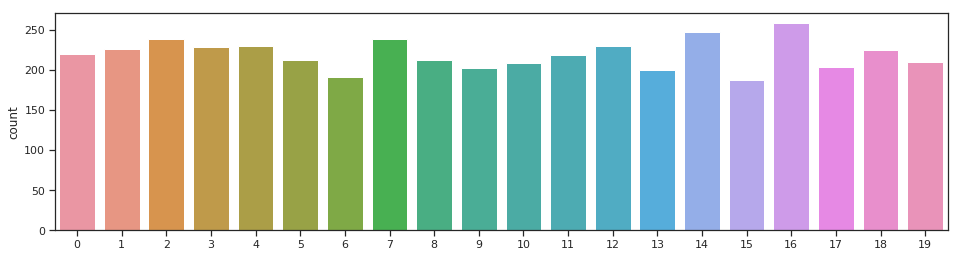

In [14]:
from sklearn.metrics.cluster import silhouette_score

random_clusters = np.random.RandomState(seed=42).randint(low=0, high=20, size=len(X))
bold('**실루엣지수(무작위군집할당) : {:8.4f}**'.format(silhouette_score(X, random_clusters)))
countplot(random_clusters)

무작위로 군집을 할당했기때문에 세그먼트별 관측치수가 비슷하며, 실루엣 지수는 -0.0375이다.   
다른 알고리즘의 실루엣지수 값이 크다면 응집도가 우수한 것으로 평가할 수 있다. 

---
**클러스터링 대표 알고리즘 실행 함수**  
알고리즘별 파라미터값 : 사이킷런의 가이드 참조

In [15]:
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 20}          # 클러스터수


def cluster_algos_pred(algo_name, algo_params={}):  
    """
    클러스터링 알고리즘 예측기
    알고리즘 옵션을 바꾸고 싶은 경우, algo_params에 값을 넣어준다.
    """
    # 파라미터 업데이트
    params = default_base.copy()
    params.update(algo_params)    
    
    # mean shift 알고리즘에 사용되는 bandwidth
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # structured Ward 알고리즘 : connectivity matrix 
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    # 클러스터링 알고리즘별 오브젝트를 만든다. 
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    
    clustering_algorithms = {
        'MiniBatchKMeans': two_means,
        'AffinityPropagation': affinity_propagation,
        'MeanShift': ms,
        'SpectralClustering': spectral,
        'Ward': ward,
        'AgglomerativeClustering': average_linkage,
        'DBSCAN': dbscan,
        'Birch': birch,
        'GaussianMixture': gmm
    }
    
    # 알고리즘 선택 후 데이터 적합
    algorithm = clustering_algorithms[algo_name]
    algorithm.fit(X)

    # 알고리즘별 predict메소드 지원여부에 따라 분리하여 예측치 산출
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    return y_pred

#### MiniBatchKMeans

**실루엣지수(two_means) :  -0.0535**

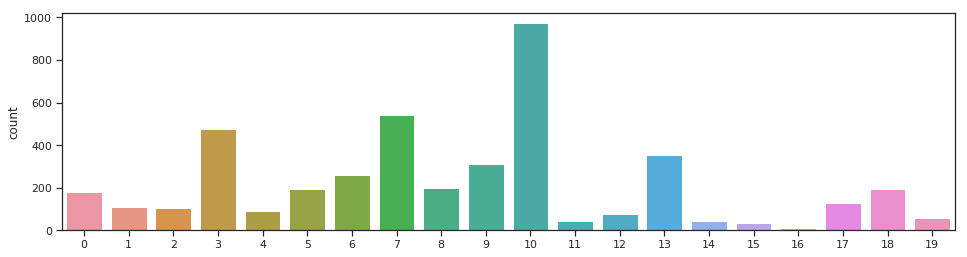

In [16]:
two_means_pred = cluster_algos_pred('MiniBatchKMeans', algo_params={'n_clusters': 20})
bold('**실루엣지수(two_means) : {:8.4f}**'.format(silhouette_score(X, two_means_pred)))
countplot(two_means_pred)

---
#### AffinityPropagation

**실루엣지수(affinity_propagation) :  -0.0534**

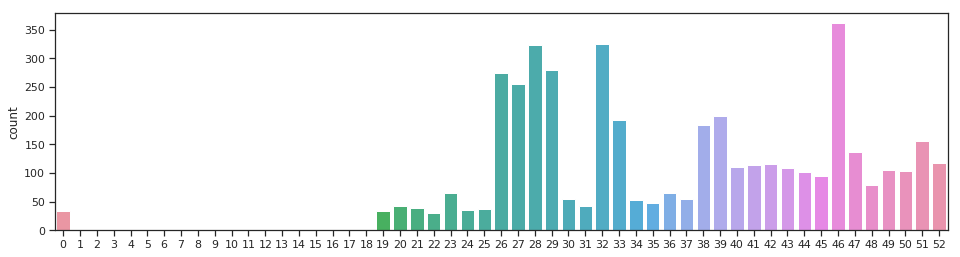

In [17]:
affinity_propagation_pred = cluster_algos_pred('AffinityPropagation')
bold('**실루엣지수(affinity_propagation) : {:8.4f}**'.format(silhouette_score(X, affinity_propagation_pred)))
countplot(affinity_propagation_pred)

---
#### MeanShift

**실루엣지수(MeanShift) :   0.3185**

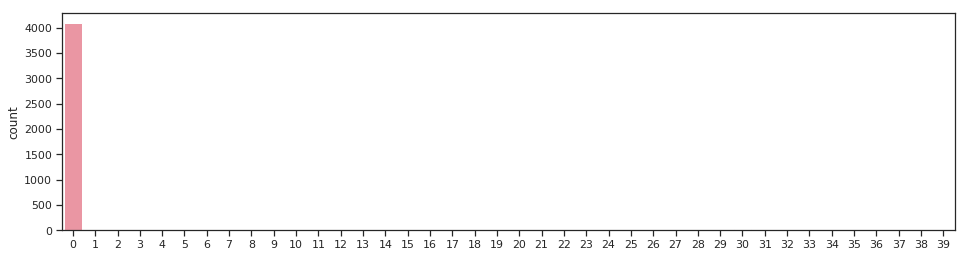

In [18]:
ms_pred = cluster_algos_pred('MeanShift')
bold('**실루엣지수(MeanShift) : {:8.4f}**'.format(silhouette_score(X, ms_pred)))
countplot(ms_pred)

In [19]:
pd.Series(ms_pred).value_counts()[:5]  

0     4086
30      21
15      15
36      14
25      13
dtype: int64

세그먼트가 하나로 뭉치고 수익률 특이값(outlier)만 39개의 소규모 세그먼트로 나뉨  
반면, 실루엣 지수는 엄청 놓게 나온다. ㅠ.ㅜ

---
#### SpectralClustering

**실루엣지수(SpectralClustering) :  -0.0469**

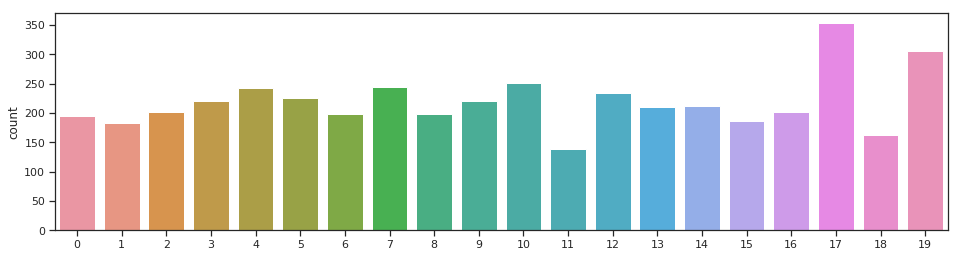

In [20]:
spectral_pred = cluster_algos_pred('SpectralClustering', 
                                   algo_params={'eigen_solver':'arpack', 'affinity':'nearest_neighbors'})
bold('**실루엣지수(SpectralClustering) : {:8.4f}**'.format(silhouette_score(X, spectral_pred)))
countplot(spectral_pred)

가장 이상적인 클러스터당 관측치 배분을 보여준다. 과연 군집간의 밀집도도 괜찮을지? 

---
#### Ward

**실루엣지수(Ward) :  -0.0075**

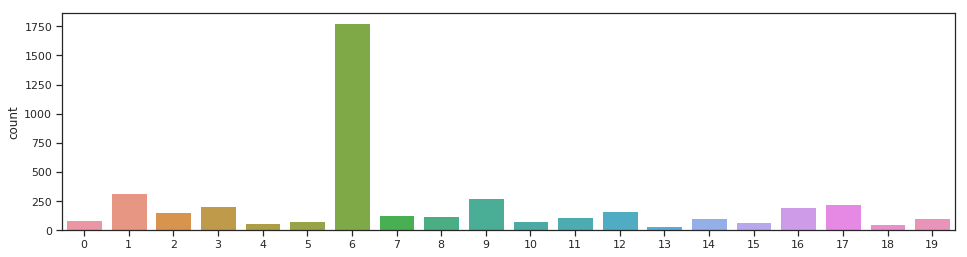

In [21]:
ward_pred = cluster_algos_pred('Ward', algo_params={'linkage':'ward', 'connectivity':'connectivity'})
bold('**실루엣지수(Ward) : {:8.4f}**'.format(silhouette_score(X, ward_pred)))
countplot(ward_pred)

---
#### Agglomerative Clustering

**실루엣지수(AgglomerativeClustering) :   0.6181**

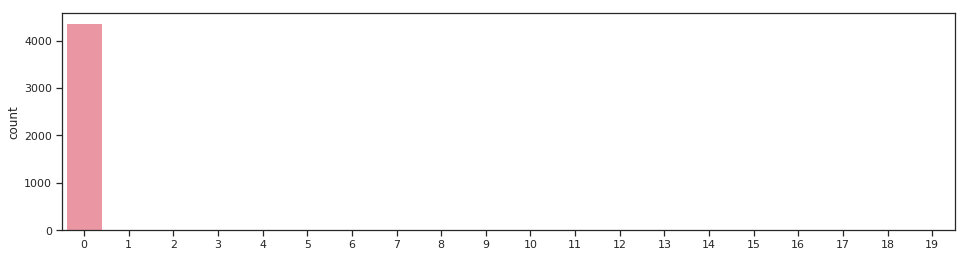

In [22]:
average_linkage_pred = cluster_algos_pred('AgglomerativeClustering',
                                          algo_params={'linkage':'average', 'affinity':'cityblock', 'connectivity':'connectivity'})
bold('**실루엣지수(AgglomerativeClustering) : {:8.4f}**'.format(silhouette_score(X, average_linkage_pred)))
countplot(average_linkage_pred)

---
#### DBSCAN

In [23]:
# ------> 돌리지 말것
dbscan_pred = cluster_algos_pred('DBSCAN', algo_params={'eps':.001})
bold('**실루엣지수(DBSCAN) : {:8.4f}**'.format(silhouette_score(X, dbscan_pred)))
countplot(dbscan_pred)

모든 관측치가 -1(=Noise)로 나옴

---
#### Birch

**실루엣지수(Birch) :   0.0179**

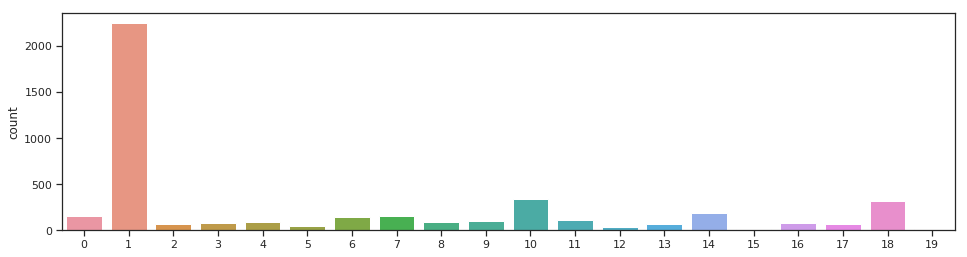

In [24]:
birch_pred = cluster_algos_pred('Birch')
bold('**실루엣지수(Birch) : {:8.4f}**'.format(silhouette_score(X, birch_pred)))
countplot(birch_pred)

---
#### GaussianMixture

**실루엣지수(GaussianMixture) :  -0.1187**

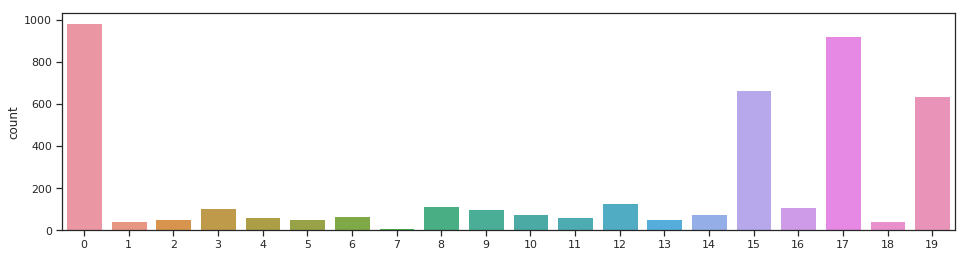

In [25]:
gmm_pred = cluster_algos_pred('GaussianMixture', algo_params={'n_components':'100', 'covariance_type':'full'})
bold('**실루엣지수(GaussianMixture) : {:8.4f}**'.format(silhouette_score(X, gmm_pred)))
countplot(gmm_pred)

---
**모델링 비교 분석 결론**  
- 세그먼트가 제대로 쪼개지지 않는 알고리즘 제외 : Affinity Propagation, Mean shfit, Agglomerative Clustering, DBSCAN, Birch
- 나머지 알고리즘은 세그먼트별 수익률 차트를 관측하여 성능 평가 : MiniBatch Kmeans, Spectral Clustering, Ward, GausianMixture
- 실루엣 지수는 주가데이터와 같이 밀집된 분포에서는 제대로 작동하지 않아 평가지표로 삼기에는 무리가 있음

---

### 대표 알고리즘 X 세그먼트별 수익률 차트 샘플 검증

In [26]:
def seg_barchart(seg_result, 
                 seg_id, 
                 N, 
                 colN, 
                 random_state=42):
    """
    세그먼트ID와 샘플수에 맞춰서 수익률 막대 차트를 그린다.
    """
    sample_ = df_kospi_lag.iloc[seg_result == seg_id].sample(N, random_state=random_state)
    sample_['DT'] = sample_.index
    melted = sample_.melt(id_vars=['DT'], value_vars=varname)

    g = sns.FacetGrid(melted, 
                      col='DT',
                      col_wrap=colN,  # 가로 갯수
                      height=3.5)  # 차트 크기
    g.map(sns.barplot, 'variable', 'value')
    g.set_xticklabels(rotation=90)

---
#### MiniBatch Kmeans

/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


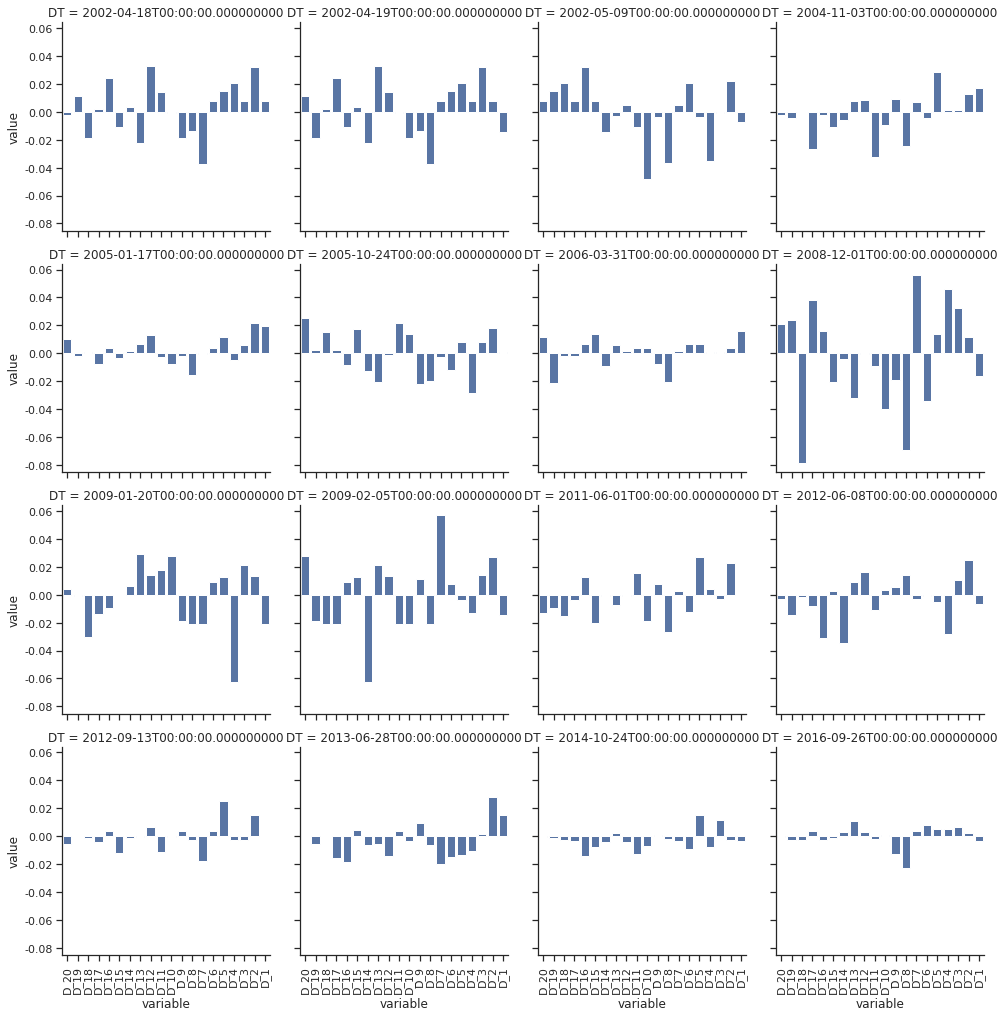

In [27]:
seg_barchart(two_means_pred, 5, 16, 4)   # 5번 세그먼트, 16개 샘플링

---
#### Spectral Clustering

/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


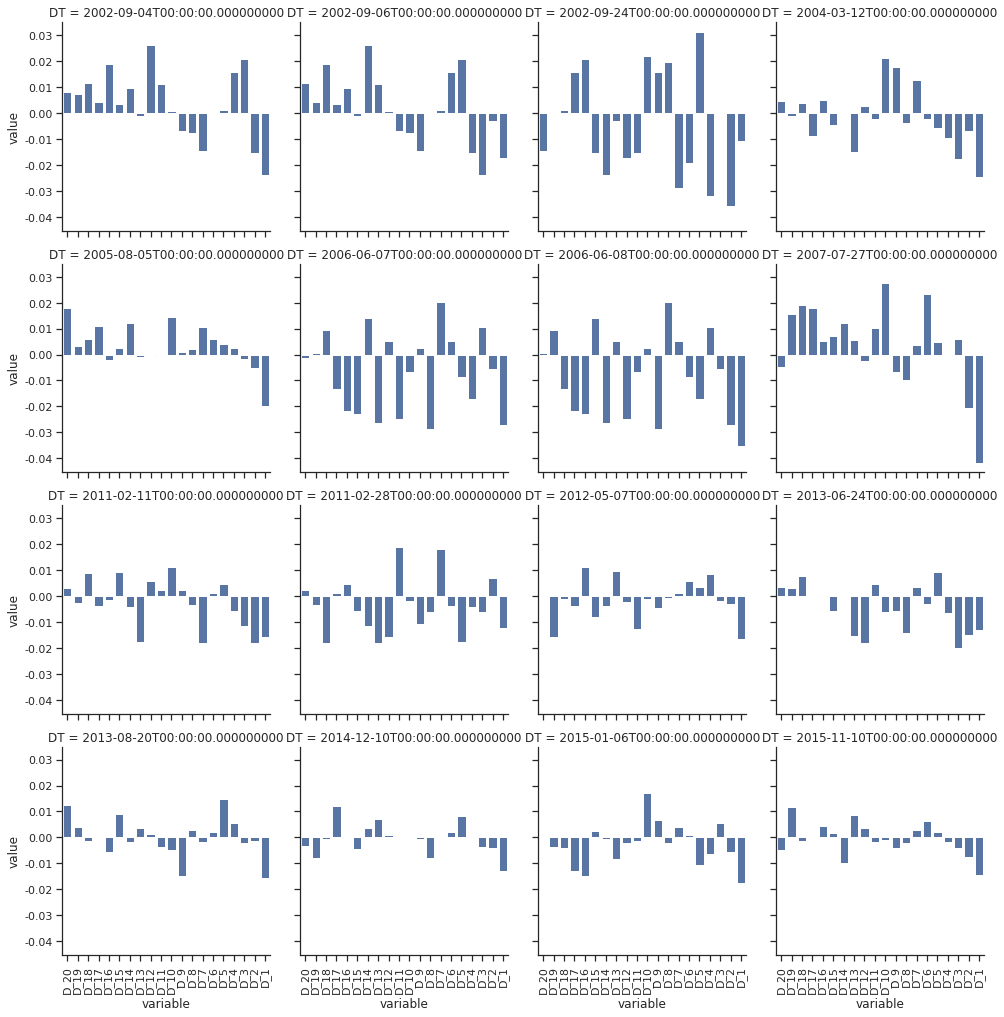

In [28]:
seg_barchart(spectral_pred, 6, 16, 4) # 6번 세그먼트, 16개 샘플링

_가장 맘에 든다!!!!_

---
#### Ward

/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


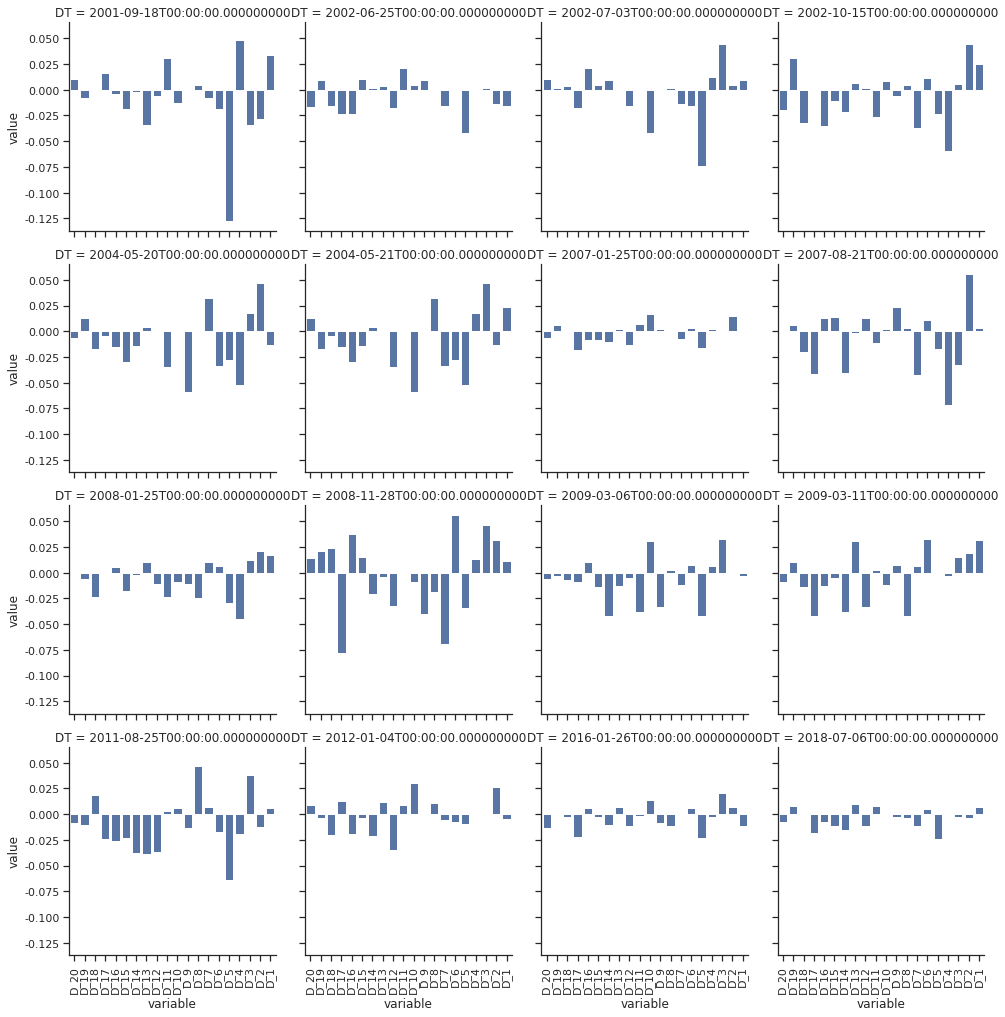

In [29]:
seg_barchart(ward_pred, 13, 16, 4)   # 13번 세그먼트, 16개 샘플링

---
#### Gausian Mixture

/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


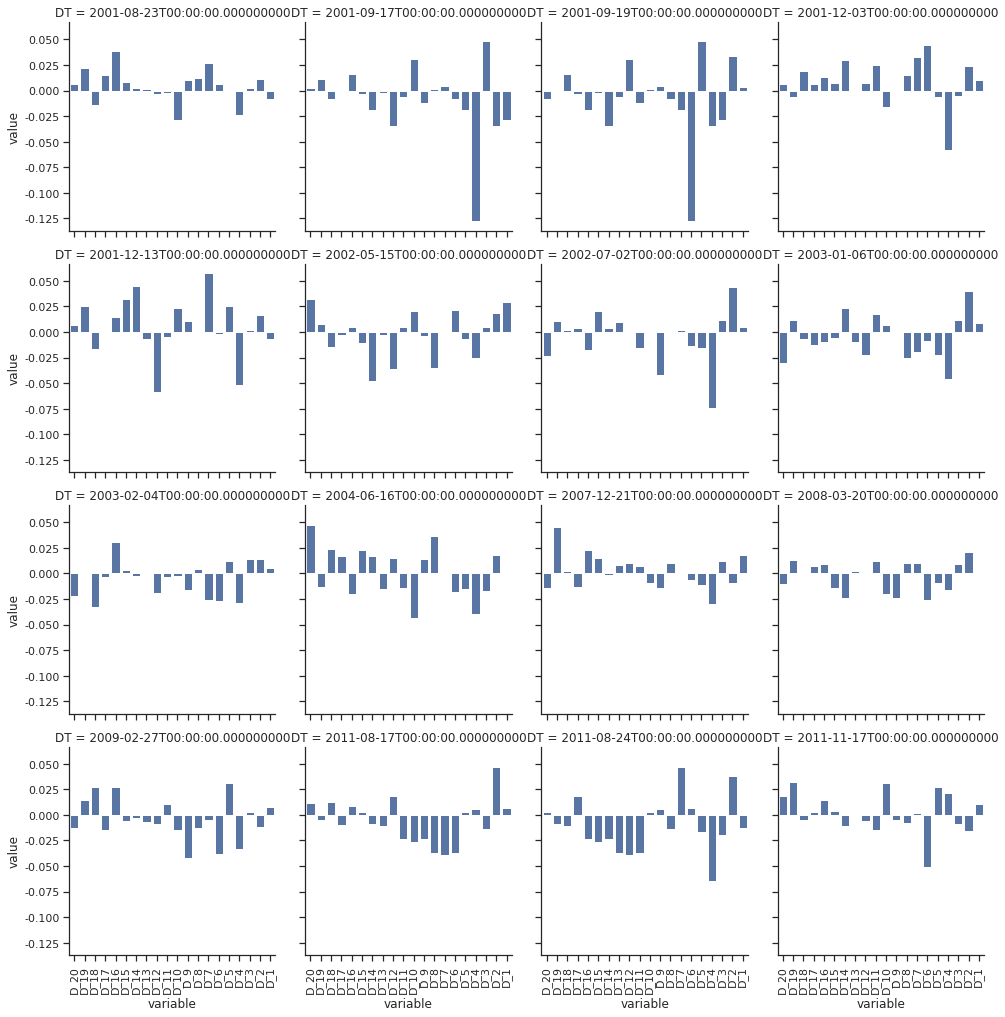

In [30]:
seg_barchart(gmm_pred, 5, 16, 4) # 5번 세그먼트, 16개 샘플링

---
- 주요 알고리즘별 세그먼트 실제 관측 결과, 유사한 일별 수익률 패턴을 보여주는 것으로 판단  
- **Spectral Clustering 결과가 가장 선명해 보임. 또한 세그먼트 당 관측치 배분도 이상적**
- 다만 실험결과가 **작은 규모의 세그먼트를 중심으로 관측한 것임에 유의**할 것  
- 예를들어, 아래 Gausian Mixture 14번 세그먼트는 관측치 천 개 이상의 대형 세그먼트로 패턴이 잘 나타나지 않음

---
#### Gausian Mixture 초대형 세그먼트

/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


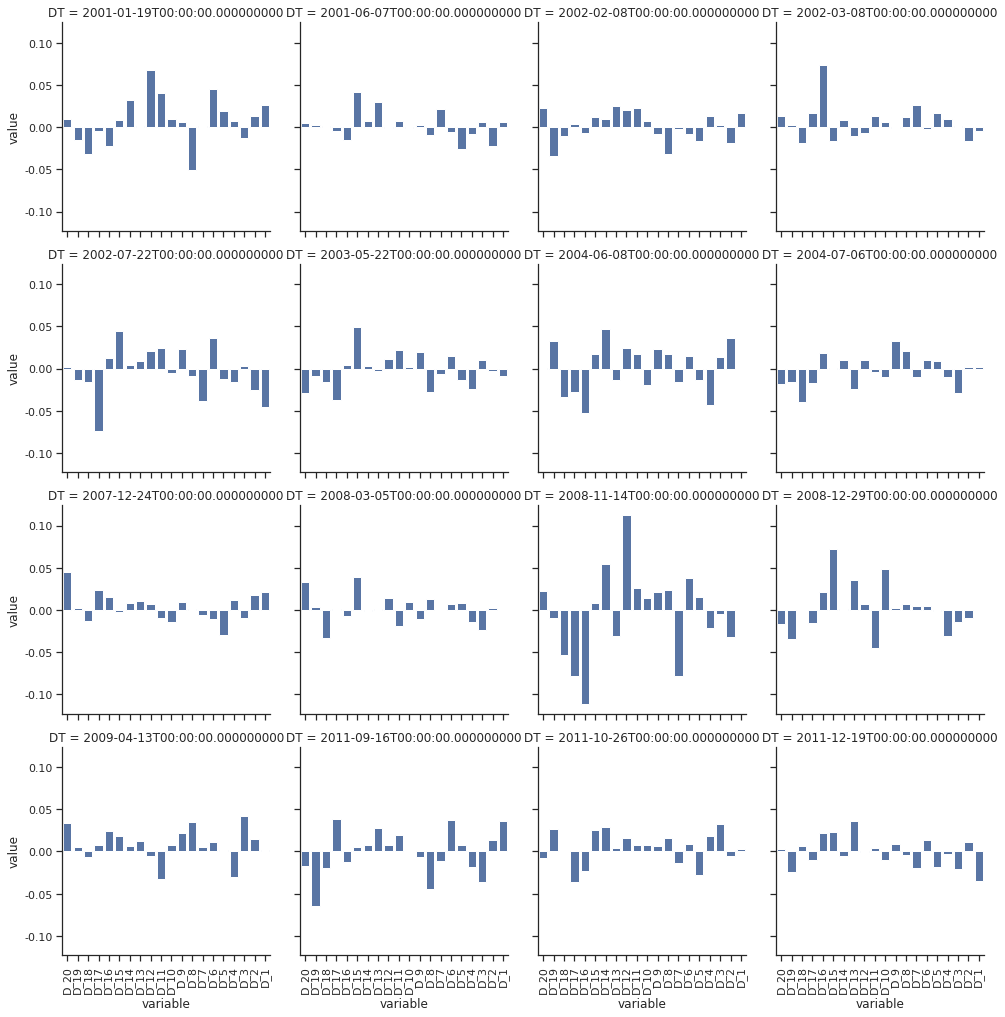

In [31]:
seg_barchart(gmm_pred, 14, 16, 4)  # Gausian Mixture의 가장 큰 14번 세그먼트 : 관측치 1천개 이상

---

# 시사점 정리

### Baseline Model 결과 
- 일별 수익률 데이터 하나만으로도 다양한 모델 검증을 통해 세그먼트 분류 가능성 확인
    
### 최종 모델 개발을 향한 제언
**1. 국면 분석의 목적은?**  
  - 상승 또는 하락 국면을 찾는 것?
  - 동일한 차트를 찾는 것?  
  
**2. 피처 엔지니어링**  
  - 피처 추가 검토 : 거래량, 상승일수, 상승/하락/보합 여부, 기술적 지수(단, 분석 목적과 합치되는 피처인 경우)
  - 피처 변형 검토 : 피처 축소(PCA), 최근일자 가중치 부여 등 연구
  
**3. 알고리즘 구현**  
  - 새로운 대안 모델 검토 : 차트 이미지 분석, 피처 간 유사도 측정(하단 별첨 참조), 지도학습/강화학습 
  - Baseline Model에서는 Spectral Clustering 알고리즘이 가장 우수한 것으로 판단

**4. 결과 검증**  
 - 군집 응집도 평가 방법 : 실루엣지수, 눈으로 실측하는 방법 외에 더 똑똑한 방법은? 
 - 세그먼트별 미래주가 분포 : D+00 일 이후 주가 상승(하락) 비중은? 

---

#### [별첨] 클러스터링의 알고리즘의 대안 : 유클리디안 거리로 과거일자 수익률 변동이 최대한 유사한 날을 찾아보자

In [32]:
from sklearn.metrics.pairwise import euclidean_distances

In [33]:
def similar_barchart(vec, colN=3):
    """ 선택된 날짜로 주가 변동 바차트 그리기 """
    sample_ = df_kospi_lag.iloc[vec]
    sample_['DT'] = sample_.index
    melted = sample_.melt(id_vars=['DT'], value_vars=varname)
 
    g = sns.FacetGrid(melted, 
                      col='DT',
                      col_wrap=colN,  # 가로 갯수
                      height=3.5)     # 차트 크기
    g.map(sns.barplot, 'variable', 'value')
    g.set_xticklabels(rotation=90)

In [34]:
def dist_similar(index_, N=9):
    """
    임의의 하루를 지정해, 주가 변동이 가장 유사했던 날을 구해보자
    유사도는 가장 보편적으로 사용하는 유클리디안 거리로 측정한다. (거리값이 0이면 일치, 거리값이 클수록 불일치)
    """
    any_day = X[index_]    
    dist = euclidean_distances(X, [any_day]).flatten()   # 0에 가까울수록 동일한 벡터이다. 
    similar_vec = np.argsort(dist)[:N]                   # 가장 유사한 날짜(작은 값) 인덱스 벡터
    print("선택일자 : ", df_kospi_lag.index[index_])
    print("거리     : ", dist[similar_vec])
    similar_barchart(similar_vec, colN=3)

#### 테스트 #1. 2017-07-28

선택일자 :  2017-07-28 00:00:00
거리     :  [0.         1.35099397 1.39699737 1.47751284 1.62795476 1.63903724
 1.681262   1.68338536 1.69334013]


/home/ncp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


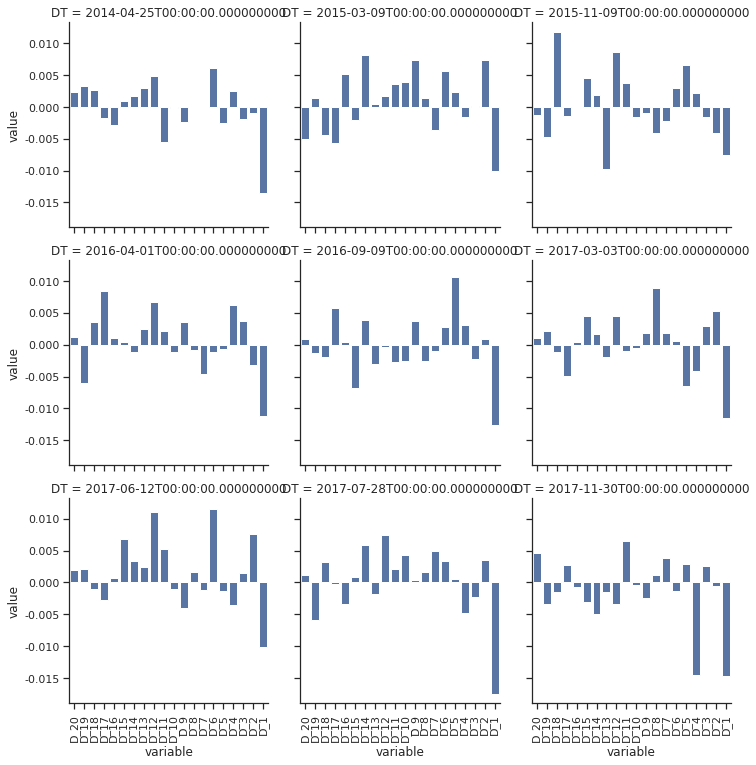

In [35]:
dist_similar(4100)  # 2017-07-28(8번째 차트)

#### 테스트 #2. 2017-12-27

선택일자 :  2017-12-27 00:00:00
거리     :  [0.         1.7516962  1.83094558 2.03307745 2.06405474 2.0691007
 2.07375832 2.09576347 2.09900636]


/home/ncp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


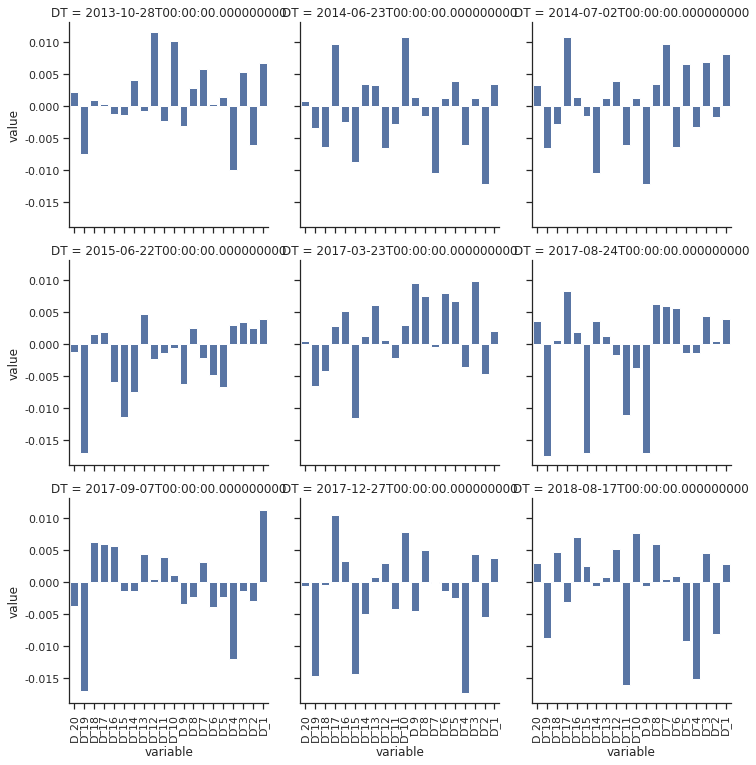

In [36]:
dist_similar(4200)  # 2017-12-27(8번째 차트)

#### 테스트 #3. 2018-05-28

선택일자 :  2018-05-28 00:00:00
거리     :  [4.21468485e-08 1.40879165e+00 1.62639192e+00 1.63173691e+00
 1.70280378e+00 1.70538472e+00 1.72857327e+00 1.74281262e+00
 1.77453238e+00]


/home/ncp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ncp/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


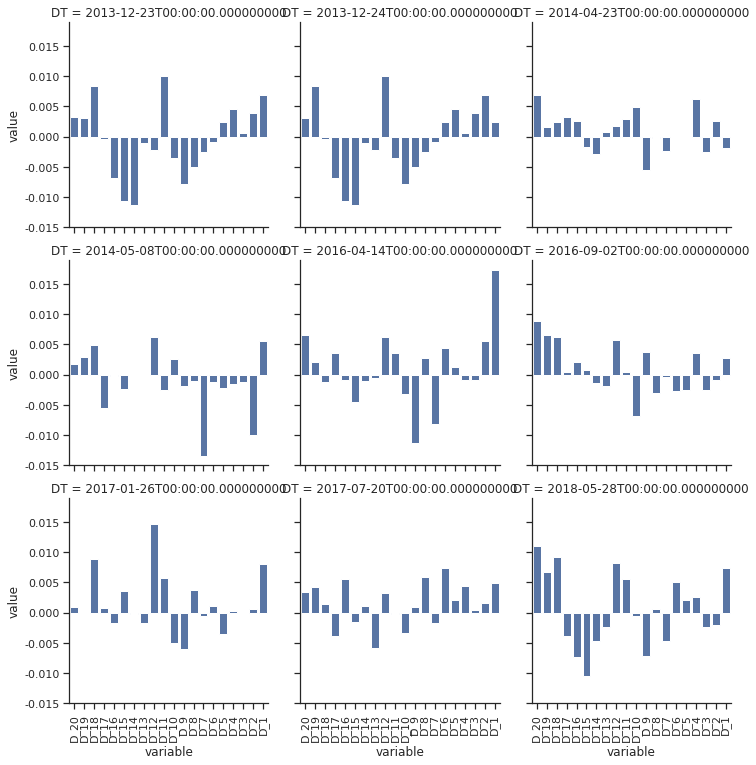

In [37]:
dist_similar(4300)   # 2018-05-28(9번째 차트)

유클리디안 거리가 0에 가까울수록 테스트 일자의 수익률과 상당히 유사한 수익률 패턴을 보임  
다만, 거리값이 증가할수록 유사도가 떨어짐